# AI 작사가 만들기 👩‍🎨

## 1. 데이터 읽어오기

In [1]:
import glob
import os
import re
import tensorflow as tf
import sklearn

In [2]:
txt_file_path = os.getenv('HOME') + '/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:20])

데이터 크기: 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you', 'By my side But then I spent so many nights', "Just thinking how you've done me wrong", 'I grew strong', "I learned how to get along And so you're back", 'From outer space', 'I just walked in to find you', 'Here without that look upon your face I should have changed that fucking lock', 'I would have made you leave your key', 'If I had known for just one second', "You'd be back to bother me Well now go,", 'Walk out the door', 'Just turn around', "Now, you're not welcome anymore Weren't you the one", 'Who tried to break me with desire?', "Did you think I'd crumble?", "Did you think I'd lay down and die? Oh not I,", 'I will survive']


## 2. 데이터 정제

### 2.1 정규표현식으로 문장 정제

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 변경 후 양쪽 공백 제거
    sentence = re.sub("\[.*\]*", " ", sentence) # 노래 구조 삭제 ex. [Outro]
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양옆에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 다수의 공백은 하나의 공백으로 처리 
    sentence = re.sub(r"[^a-z?.!,¿]+", " ", sentence) # 영어와 지정한 특수문자 제외 공백 처리 
    sentence = sentence.strip() # 양쪽 공백 삭제
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작에는 <start>, 끝에는 <end>를 추가
    return sentence

print(preprocess_sentence(raw_corpus[0]))# 정제 결과 확인

<start> at first i was afraid <end>


In [4]:
corpus = [] # 정제된 말뭉치를 저장

for sentence in raw_corpus:
    # 원치않는 문장 건너뛰기
    if len(sentence) == 0 or len(sentence.split()) > 15: continue # 길이가 0이거나 토큰이 15개가 넘는 문장은 건너뛰기
#     if sentence[-1] == ":": continue # 가사가 ':'으로 마치는 경우 존재하므로 건너뛰지 않는다
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과 확인
print(len(corpus))
corpus[1:20]

168590


['<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> here without that look upon your face i should have changed that fucking lock <end>',
 '<start> i would have made you leave your key <end>',
 '<start> if i had known for just one second <end>',
 '<start> you d be back to bother me well now go , <end>',
 '<start> walk out the door <end>',
 '<start> just turn around <end>',
 '<start> now , you re not welcome anymore weren t you the one <end>',
 '<start> who tried to break me with desire ? <end>',
 '<start> did you think i d crumble ? <end>',
 '<start> did you think i d lay down and die ? oh not i , <end>',
 '<start> i will survive <end>']

### 2.2 Tokenization

In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, # 단어장의 크기(전체 단어의 개수) 
        filters=' ',
        oov_token="<unk>" # 사전에 없는 단어 <unk>으로 대체
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   71  250 ...    0    0    0]
 [   2    5   57 ...    0    0    0]
 [   2    5 1103 ...    0    0    0]
 ...
 [   2   47   16 ...    0    0    0]
 [  24    9 2887 ...  261   19    3]
 [   2    6  176 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f079aad4c90>


In [6]:
print(tensor[:3, :15]) # 생성된 텐서 데이터 3번째 행 부터 15번째 열까지 출력
tensor.shape

[[   2   71  250    5   57  644    3    0    0    0    0    0    0    0
     0]
 [   2    5   57 6670    3    0    0    0    0    0    0    0    0    0
     0]
 [   2    5 1103  510    5  104   79  202  257    7    3    0    0    0
     0]]


(168590, 15)

In [7]:
# 단어사전 확인
len(tokenizer.index_word)
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break #단어장의 10번째 단어까지 출력

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


## 3. 평가 데이터셋 분리

In [8]:
src_input = tensor[:, :-1] # 마지막 토큰을 잘라, 소스 문장 생성
tgt_input = tensor[:, 1:] # <start>를 잘라, 타겟 문장 생성
print(src_input[0])
print(tgt_input[0])

[  2  71 250   5  57 644   3   0   0   0   0   0   0   0]
[ 71 250   5  57 644   3   0   0   0   0   0   0   0   0]


In [9]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val:", enc_val.shape)
print("Target Val:", dec_val.shape)

Source Train: (134872, 14)
Target Train: (134872, 14)
Source Val: (33718, 14)
Target Val: (33718, 14)


## 4. 모델 설계 및 훈련

__조건__: 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하라

### 4.1 1차 모델 설계 (하이퍼파라미터 조정)

__데이터__
- Source Train: (134872, 14)
- Target Train: (134872, 14)
- Source Validation: (33718, 14)
- Target Validation: (33718, 14)


__모델설계__

[Model1]
- RNN 레이어 2개
- embedding_size = 256
- hidden_size = 1024
- n_train_epoch = 10

[Model2]
- RNN 레이어 2개
- embedding_size = 512
- hidden_size = 1024
- n_train_epoch = 10  

[Model3]
- RNN 레이어 2개
- embedding_size = 1024
- hidden_size = 1024
- n_train_epoch = 10  


__실행방법__

훈련셋을 train,validation으로 분리한다. __하이퍼파라미터__를 조정하며 train으로 훈련하고 validation으로 loss를 평가한다.최종 평가는 생성하는 문장을 확인한다.

__결과__

Train과 validation의 loss 결과<br>
참고용으로 확인한 loss 

[Model1] 
loss: 2.2189 - val_loss: 2.5852

[Model2]
loss: 2.0250 - val_loss: 2.4940

[Model3]
loss: 2.0079 - val_loss: 2.4921

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

> __return_sequences=True__<br>
    return_sequences=True for all LSTM layers except the last one.    
    Setting this flag to True lets Keras know that LSTM output should contain all historical generated outputs along with time stamps (3D). So, next LSTM layer can work further on the data.
    If this flag is false, then LSTM only returns last output (2D). Such output is not good enough for another LSTM layer.

In [11]:
# model 1
vocab_size = tokenizer.num_words + 1 # 총 단어 개수 + pad:0
embedding_size = 256 # 단어가 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 둘 일꾼의 수(많으면 배가 산으로)
model = TextGenerator(vocab_size, embedding_size , hidden_size)

In [12]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(256, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.09650093e-04,  7.55700967e-05,  4.64430668e-05, ...,
         -6.37245976e-05, -8.88853610e-05,  3.32817173e-04],
        [ 4.25293256e-05, -1.16485593e-04,  4.01814235e-04, ...,
         -1.28365733e-04, -5.76188722e-05,  1.76828747e-04],
        [ 1.28811153e-04, -2.26286182e-04,  6.32244628e-04, ...,
         -1.32657384e-04, -2.24731411e-04,  2.32255203e-04],
        ...,
        [ 7.03075202e-04,  9.25957051e-04, -6.55797194e-05, ...,
         -5.83082801e-05, -5.87891089e-04,  3.84218409e-04],
        [ 7.44950143e-04,  6.10340387e-04, -1.56804560e-06, ...,
         -1.56189097e-04, -7.44727382e-04,  5.23206021e-04],
        [ 6.44089538e-04,  4.97802917e-04,  1.64057987e-04, ...,
         -4.77595953e-04, -9.87384701e-04,  4.48294682e-04]],

       [[ 2.31161204e-04, -6.61938902e-05, -8.36381150e-05, ...,
         -8.25635434e-05, -5.12118895e-05,  1.52420078e-04],
        [ 6.37488192e-05, -3.13662749e-04,  2

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [23]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
.
model.compile(loss=loss, optimizer=optimizer)

hist = model.fit(enc_train, 
          dec_train, 
          epochs=10,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
527/527 [==============================] - 202s 378ms/step - loss: 4.1540 - val_loss: 3.2652
Epoch 2/10
527/527 [==============================] - 199s 377ms/step - loss: 3.1814 - val_loss: 3.0784
Epoch 3/10
527/527 [==============================] - 200s 379ms/step - loss: 2.9866 - val_loss: 2.9583
Epoch 4/10
527/527 [==============================] - 200s 380ms/step - loss: 2.8402 - val_loss: 2.8646
Epoch 5/10
527/527 [==============================] - 198s 376ms/step - loss: 2.7143 - val_loss: 2.7934
Epoch 6/10
527/527 [==============================] - 200s 380ms/step - loss: 2.6009 - val_loss: 2.7345
Epoch 7/10
527/527 [==============================] - 199s 377ms/step - loss: 2.4979 - val_loss: 2.6946
Epoch 8/10
527/527 [==============================] - 199s 377ms/step - loss: 2.4026 - val_loss: 2.6488
Epoch 9/10
527/527 [==============================] - 200s 379ms/step - loss: 2.2992 - val_loss: 2.6155
Epoch 10/10
527/527 [==============================] - 199s 378m

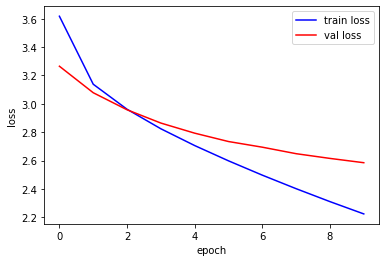

In [28]:
# 학습 그래프 그리기
def loss_graph(history):
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()

    loss_ax.plot(history.history['loss'], 'b', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')

    loss_ax.legend(loc='upper right')

    plt.show()
    return None

In [29]:
# model 2
embedding_size = 512
hidden_size = 1024
model2 = TextGenerator(vocab_size, embedding_size , hidden_size)
model2(src_sample)
model2.summary()
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model2.compile(loss=loss, optimizer=optimizer)

hist = model2.fit(enc_train, dec_train, 
          epochs=10,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  6144512   
_________________________________________________________________
lstm_4 (LSTM)                multiple                  6295552   
_________________________________________________________________
lstm_5 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_2 (Dense)              multiple                  12301025  
Total params: 33,133,793
Trainable params: 33,133,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
527/527 [==============================] - 210s 392ms/step - loss: 4.0869 - val_loss: 3.2006
Epoch 2/10
527/527 [==============================] - 209s 396ms/step - loss: 3.1079 - val_loss: 2.9859
Epoch 3/10
527/527 [========

In [14]:
# model 3
embedding_size = 1024
hidden_size = 1024
model3 = TextGenerator(vocab_size, embedding_size , hidden_size)
model3(src_sample)
model3.summary()
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model3.compile(loss=loss, optimizer=optimizer)

hist = model3.fit(enc_train, dec_train, 
          epochs=10,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  12289024  
_________________________________________________________________
lstm_2 (LSTM)                multiple                  8392704   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 41,375,457
Trainable params: 41,375,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
527/527 [==============================] - 217s 407ms/step - loss: 4.0040 - val_loss: 3.1382
Epoch 2/10
527/527 [==============================] - 217s 412ms/step - loss: 3.0434 - val_loss: 2.9465
Epoch 3/10
527/527 [========

***

### 4.2 2차 모델 설계 (레이어 추가)

__데이터__
- Source Train: (134872, 14)
- Target Train: (134872, 14)
- Source Validation: (33718, 14)
- Target Validation: (33718, 14)


__모델설계__

[Model4]
- RNN 레이어 3개
- embedding_size = 256
- hidden_size = 1024
- n_train_epoch = 10

[Model5]
- RNN 레이어 3개
- embedding_size = 512
- hidden_size = 1024
- n_train_epoch = 10  

[Model6]
- RNN 레이어 3개
- embedding_size = 1024
- hidden_size = 1024
- n_train_epoch = 10  


__실행방법__

훈련셋을 train,validation으로 분리한다. 설계된 모델은 기존보다 RNN레이어를 한 층 더 추가하였다,  __하이퍼파라미터__를 조정하며 train으로 훈련하고 validation으로 loss를 평가한다.최종 평가는 생성하는 문장을 확인한다.

__결과__

Train과 validation의 loss 결과<br>
참고용으로 확인한 loss 

[Model4] 
loss: 2.5717  - val_loss: 2.7989

[Model5]
loss: 2.5000  - val_loss: 2.7536

[Model6]
loss: 2.4000  - val_loss: 2.7019

In [15]:
# 모델 설계
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.rnn_3(out)
        out = self.linear(out)
        
        return out

In [17]:
# 모델 훈련 및 검증 함수
def train_val_model(embedding_size, hidden_size):
    model = TextGenerator(vocab_size, embedding_size , hidden_size)
#     model(src_sample)
#     model.summary()

    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    model.compile(loss=loss, optimizer=optimizer)

    hist = model.fit(enc_train, dec_train, 
              epochs=10,
              batch_size=256,
              validation_data=(enc_val, dec_val),
              verbose=1)
    return hist

In [19]:
# model 4
hist4 = train_val_model(256, 1024)

Epoch 1/10
527/527 [==============================] - 243s 448ms/step - loss: 4.1457 - val_loss: 3.3113
Epoch 2/10
527/527 [==============================] - 237s 450ms/step - loss: 3.2490 - val_loss: 3.1979
Epoch 3/10
527/527 [==============================] - 238s 451ms/step - loss: 3.1376 - val_loss: 3.1055
Epoch 4/10
527/527 [==============================] - 239s 453ms/step - loss: 3.0137 - val_loss: 3.0254
Epoch 5/10
527/527 [==============================] - 240s 455ms/step - loss: 2.9204 - val_loss: 2.9699
Epoch 6/10
527/527 [==============================] - 239s 454ms/step - loss: 2.8305 - val_loss: 2.9189
Epoch 7/10
527/527 [==============================] - 239s 453ms/step - loss: 2.7533 - val_loss: 2.8791
Epoch 8/10
527/527 [==============================] - 239s 453ms/step - loss: 2.6873 - val_loss: 2.8488
Epoch 9/10
527/527 [==============================] - 239s 453ms/step - loss: 2.6303 - val_loss: 2.8248
Epoch 10/10
527/527 [==============================] - 238s 452m

In [20]:
# model 5
hist5 = train_val_model(512, 1024)

Epoch 1/10
527/527 [==============================] - 256s 472ms/step - loss: 4.1406 - val_loss: 3.2830
Epoch 2/10
527/527 [==============================] - 248s 470ms/step - loss: 3.2036 - val_loss: 3.1203
Epoch 3/10
527/527 [==============================] - 248s 471ms/step - loss: 3.0388 - val_loss: 3.0244
Epoch 4/10
527/527 [==============================] - 248s 471ms/step - loss: 2.9252 - val_loss: 2.9543
Epoch 5/10
527/527 [==============================] - 248s 470ms/step - loss: 2.8418 - val_loss: 2.9119
Epoch 6/10
527/527 [==============================] - 247s 470ms/step - loss: 2.7584 - val_loss: 2.8656
Epoch 7/10
527/527 [==============================] - 247s 469ms/step - loss: 2.6851 - val_loss: 2.8319
Epoch 8/10
527/527 [==============================] - 247s 469ms/step - loss: 2.6203 - val_loss: 2.7995
Epoch 9/10
527/527 [==============================] - 246s 467ms/step - loss: 2.5559 - val_loss: 2.7807
Epoch 10/10
527/527 [==============================] - 247s 468m

In [21]:
# model 6
hist6 = train_val_model(1024, 1024)

Epoch 1/10
527/527 [==============================] - 282s 523ms/step - loss: 4.0708 - val_loss: 3.2527
Epoch 2/10
527/527 [==============================] - 274s 521ms/step - loss: 3.1687 - val_loss: 3.0913
Epoch 3/10
527/527 [==============================] - 275s 521ms/step - loss: 3.0061 - val_loss: 2.9902
Epoch 4/10
527/527 [==============================] - 275s 521ms/step - loss: 2.8790 - val_loss: 2.9224
Epoch 5/10
527/527 [==============================] - 274s 521ms/step - loss: 2.7750 - val_loss: 2.8653
Epoch 6/10
527/527 [==============================] - 274s 520ms/step - loss: 2.7001 - val_loss: 2.8212
Epoch 7/10
527/527 [==============================] - 274s 520ms/step - loss: 2.6154 - val_loss: 2.7842
Epoch 8/10
527/527 [==============================] - 274s 520ms/step - loss: 2.5389 - val_loss: 2.7500
Epoch 9/10
527/527 [==============================] - 274s 520ms/step - loss: 2.4685 - val_loss: 2.7238
Epoch 10/10
527/527 [==============================] - 273s 518m

LSTM 레이어를 더 추가했지만 정확도는 기존 심층 LSTM에 비해 떨어지는 것을 볼 수 있다.😥<br>
레이어 추가 외에 RNN을 개선하는 방법에는 양방향 RNN이 있다고 한다..!

> ### 양방향 RNN (Bidirectional RNN)
    - 기존의 RNN은 한 방향(forwad)으로 학습이 진행되지만, 양방향 RNN은 역방향으로의 순서도 고려하여 학습하는 모델이다.
    - 두 개의 RNN모델(순방향, 역방향)을 만들어 학습 결과를 합치는 모델에 가깝다.
![bidirectional_RNN](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/bidirectional-rnn.png)
[참고](https://buomsoo-kim.github.io/keras/2019/07/29/Easy-deep-learning-with-Keras-20.md/)

### 4.3 3차 모델 설계 (양방향 RNN)

__데이터__
- Source Train: (134872, 14)
- Target Train: (134872, 14)
- Source Validation: (33718, 14)
- Target Validation: (33718, 14)


__모델설계__

[Model7]
- 양방향 RNN 레이어 2개
- embedding_size = 256
- hidden_size = 1024
- n_train_epoch = 10

[Model8]
- \<start>, \<end>를 제거한 데이터셋
- 양방향 RNN 레이어 2개
- embedding_size = 256
- hidden_size = 1024
- n_train_epoch = 10

[Model9]
- \<start>, \<end>를 제거한 데이터셋
- 양방향 RNN 레이어 2개
- Dropout 레이어 1개
- embedding_size = 256
- hidden_size = 1024
- n_train_epoch = 10


__실행방법__

훈련셋을 train,validation으로 분리한다. 양방향 LSTM 레이어를 쌓아 train으로 훈련하고 validation으로 loss를 평가한다.필요한 경우 과적합을 방지하기 위해 dropout 레이어를 추가하여 모델을 설계하고 훈련시켰다. 최종 평가는 생성하는 문장을 확인한다.

__결과__

Train과 validation의 loss 결과<br>
참고용으로 확인한 loss 

[Model7] 
loss: 2.5892e-04 - val_loss: 0.0669 # over fitting

[Model8] 
loss: 6.4103e-04 - val_loss: 0.0902

[Model9] 시간관계상 모델을 돌려보지 못했다 추후 시도해볼 예정


In [14]:
# 모델 설계
from keras.layers import Bidirectional

class TextGenerator_Bidirectional(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
        self.rnn_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [12]:
# 모델 훈련 및 검증 함수
vocab_size =tokenizer.num_words + 1
def train_val_model(embedding_size, hidden_size):
    model = TextGenerator_Bidirectional(vocab_size, embedding_size , hidden_size)
#     model(src_sample)
#     model.summary()

    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    model.compile(loss=loss, optimizer=optimizer)

    hist = model.fit(enc_train, dec_train, 
              epochs=10,
              batch_size=256,
              validation_data=(enc_val, dec_val),
              verbose=1)
    return model, hist

In [42]:
# model 7
model, hist7 = train_val_model(256, 1024)

Epoch 1/10
527/527 [==============================] - 437s 813ms/step - loss: 3.0920 - val_loss: 0.4181
Epoch 2/10
527/527 [==============================] - 428s 812ms/step - loss: 0.2566 - val_loss: 0.1365
Epoch 3/10
527/527 [==============================] - 430s 815ms/step - loss: 0.0500 - val_loss: 0.0909
Epoch 4/10
527/527 [==============================] - 431s 819ms/step - loss: 0.0101 - val_loss: 0.0747
Epoch 5/10
527/527 [==============================] - 429s 814ms/step - loss: 0.0028 - val_loss: 0.0676
Epoch 6/10
527/527 [==============================] - 427s 810ms/step - loss: 0.0012 - val_loss: 0.0643
Epoch 7/10
527/527 [==============================] - 426s 809ms/step - loss: 0.0103 - val_loss: 0.1200
Epoch 8/10
527/527 [==============================] - 431s 818ms/step - loss: 0.0182 - val_loss: 0.0775
Epoch 9/10
527/527 [==============================] - 432s 820ms/step - loss: 0.0013 - val_loss: 0.0686
Epoch 10/10
527/527 [==============================] - 431s 818m

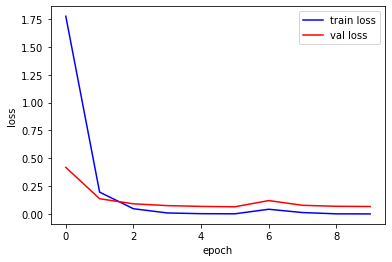

In [43]:
loss_graph(hist7)

corpus에서 \<start>와 \<end>를 제거하고 학습시켜보자

In [10]:
# 데이터 준비
new_corpus = [] # 새로운 말뭉치 준비
for line in corpus:
    new_line = re.sub("(\<[a-z]+\>)", " ", line) # <start>, <end> 삭제
    new_line = new_line.strip() # 양쪽 공백 삭제
    new_corpus.append(new_line)
    
    
# Tokenization
tensor, tokenizer = tokenize(new_corpus) 

# 평가 데이터셋 분리
src_input = tensor[:, :-1] # 마지막 토큰을 잘라, 소스 문장 생성
tgt_input = tensor[:, 1:] # 첫 토큰을 잘라, 타겟 문장 생성

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val:", enc_val.shape)
print("Target Val:", dec_val.shape)

[[  69  248    3 ...    0    0    0]
 [   3   55 6668 ...    0    0    0]
 [   3 1101  508 ...    0    0    0]
 ...
 [  45   14   95 ...    0    0    0]
 [  20   22    7 ...   43  259   17]
 [   4  174   15 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7ff1d738c590>
Source Train: (134872, 14)
Target Train: (134872, 14)
Source Val: (33718, 14)
Target Val: (33718, 14)


In [15]:
# 모델 훈련 
# model 8
model8, hist8 = train_val_model(256, 1024) # 마지막으로 설계된 모델 그대로 사용(TextGenerator_Bidirectional)

Epoch 1/10
527/527 [==============================] - 403s 745ms/step - loss: 2.8369 - val_loss: 0.4508
Epoch 2/10
527/527 [==============================] - 399s 756ms/step - loss: 0.3203 - val_loss: 0.1979
Epoch 3/10
527/527 [==============================] - 402s 763ms/step - loss: 0.0932 - val_loss: 0.1271
Epoch 4/10
527/527 [==============================] - 401s 762ms/step - loss: 0.0282 - val_loss: 0.1063
Epoch 5/10
527/527 [==============================] - 403s 764ms/step - loss: 0.0121 - val_loss: 0.0957
Epoch 6/10
527/527 [==============================] - 403s 765ms/step - loss: 0.0062 - val_loss: 0.0920
Epoch 7/10
527/527 [==============================] - 404s 767ms/step - loss: 0.0255 - val_loss: 0.1158
Epoch 8/10
527/527 [==============================] - 406s 770ms/step - loss: 0.0083 - val_loss: 0.0983
Epoch 9/10
527/527 [==============================] - 405s 768ms/step - loss: 0.0018 - val_loss: 0.0915
Epoch 10/10
527/527 [==============================] - 405s 769m

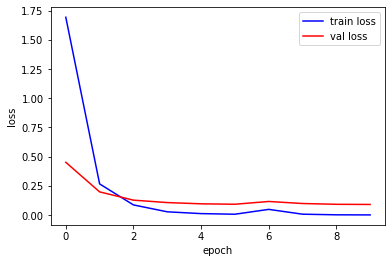

In [21]:
loss_graph(hist8)

## 5. 모델 평가
작사가 모델이 쓴 가사를 평가해본다.

__모델별 생성된 문장__

|init_sentence|model3|model7😈|model8|
|:---:|:---:|:---:|:---:|
|\<start> her smile|\<start> her smile fades in the sky \<end> |\<start> her smile \<end>|her smile |
|\<start> i love|\<start> i love you , liberian girl \<end> |\<start> i love \<end>|i love you|
|\<start> you re|\<start> you re the only one who knows that \<end>|\<start> you re \<end>|you re fading tired , oh . |
|\<start> a letter|\<start> a letter of me and i know \<end> |\<start> a letter \<end>|a letter of heaven |
|\<start> you make|\<start> you make me wanna get you pregnant than you \<end> |\<start> you make \<end>|you make me happy|
|※model8에 init_setence에는 \<start>없이 테스트

In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [18]:
# model3 평가하기
print(generate_text(model3, tokenizer, init_sentence="<start> her smile"))
print(generate_text(model3, tokenizer, init_sentence="<start> i love"))
print(generate_text(model3, tokenizer, init_sentence="<start> you re"))
print(generate_text(model3, tokenizer, init_sentence="<start> a letter"))
print(generate_text(model3, tokenizer, init_sentence="<start> you make"))

<start> her smile fades in the sky <end> 
<start> i love you , liberian girl <end> 
<start> you re the only one who knows that <end> 
<start> a letter of me and i know <end> 
<start> you make me wanna get you pregnant than you <end> 


In [46]:
# model7 평가하기
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love <end> '

양방향 RNN을 사용해서 학습된 model7이 생성해주는 문장 모두 입력된 문장에 \<end>만 붙여준다....😨 작사가가 아니라 엔드빌런을 만들었네...
<br>모든 문장이\<start>로 시작되어 \<end>로 끝이나니 \<end>만 붙여주면 된다고 overfitting되어 학습된 것 같다..

In [43]:
# <end> token이 존재하지 않으므로 해당 조건 삭제
def generate_text(model, tokenizer, init_sentence="start", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
#     end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
#         if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        if word_index == 0: #pading으로 넣은 0은 인덱스가 아니니 pass
            continue
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
# model8 평가하기

print(generate_text(model8, tokenizer, init_sentence="her smile"))
print(generate_text(model8, tokenizer, init_sentence="i love"))
print(generate_text(model8, tokenizer, init_sentence="you re"))
print(generate_text(model8, tokenizer, init_sentence="a letter"))
print(generate_text(model8, tokenizer, init_sentence="you make"))

모델의 정량적 결과만 두고 본다면 양방향으로 학습된 LSTM이 훨씬 좋은 수치를 보이지만, 문장들을 비교했을 때 모델 학습이 잘 되었다고 하기는 어려울 것 같다.

***

## 프로젝트 정리


### 핵심개념

__RNN__
- 순환신경망은 은닉계층에 이전 정보를 기억시킬 수 있는 방향을 가지고 순환구조를 이루는 인공신경망의 한 종류이다.
- 음성, 문자 등 순차적인(Sequential) 데이터 처리에 적합하다.
- 이전 출력 결과의 영향을 받아 현재까지 계산된 결과를 메모리에 기억한다는 장점
- 출력값이 곱해지는 단계가 반복되면 그 값이 소실되어 학습이 더 이상 이루어지지 않는 Vanishing gradien가 발생한다.(Long-Term dependencies 문제를 발생시킨다.)

__BRNN__
- RNN은 입력 순서를 순서대로(순방향) 처리하기 때문에 예측결과가 직전 패턴을 기반으로 하는 경향을 보이는 한계가 있다.
- BRNN은 서로 연결되지 않는 두 개의 은닉층을 가지고 순방향, 역방향으로 분리된 순환신경망을 통해 학습시키기 때문에 예측정확도를 향상시킨다.

__LSTM__
- RNN의 기울기가 사라지는 Long-Term dependencies 문제를 극복하기 위해 제안된 RNN 구조
- 시계열 데이터와 같은 긴 순서의 데이터에도 기울기 소실 문제없이 처리하게 한다.

__Dropout__
- 신경망의 뉴런들을 확률적으로 사용하지 않음으로써 과적합을 방지하는 기술
- 모델의 일반화 성능을 향상시킨다. 

(https://www.koreascience.or.kr/article/JAKO202034352378448.pdf}


### 시도해본 것

1. 2-layer LSTM 

2. 3-layer LSTM

3. 2-layer Bidirect LSTM


### 이후에 더 시도해볼 것

- 최적의 하이퍼 파라미터 찾기 (Grid Search랑 비교하여 진행해보기)
- 양방향 RNN 모델에서 Dropout 이용해 과적합 줄이기


### 기타

- [History of model](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    - model.fit을 object로 받으면 history 객체를 얻을 수 있어, epoch 별로 변화되는 추이를 그래프로 표현할 수 있다.
    - history 객체가 갖고있는 정보: 매 epoch 마다 손실값(loss), 훈련 정확도(accuracy), 검증 손실값(val_loss), 검증 정확도(val_accuracy)

    
- save and load models<br>
> 학습이 오래 걸리는 편이라 중간에 학습이 멈추거나 나중에 다시 그 모델의 결과를 확인하고 싶을때 모델을 다시 훈련시키는데 어려움이 있었다. 이럴 때 checkpoint를 사용할 수 있다고 한다.
    - [ModelCheckpoint](https://www.tensorflow.org/tutorials/keras/save_and_load): 훈련중간과 마지막에 checkpoint를 자동으로 저장, 모델을 재사용하거나 훈련과정이 중지된 경우 이어서 훈련을 진행 할 수 있다.
